In [8]:
import json
import uproot
import uproot_methods
import awkward
import numpy as np
from fnal_column_analysis_tools.analysis_objects import JaggedCandidateArray
import fnal_column_analysis_tools.hist as hist
from fnal_column_analysis_tools.hist import plot
%matplotlib nbagg
import matplotlib.pyplot as plt

def nanoObject(tree, prefix):
    branches = set(k.decode('ascii') for k in tree.keys() if k.decode('ascii')[:len(prefix)] == prefix)
    p4branches = [prefix + k for k in ['pt', 'eta', 'phi', 'mass']]
    branches -= set(p4branches)
    objp4 = uproot_methods.TLorentzVectorArray.from_ptetaphim(*[tree[b].array() for b in p4branches])
    branches = {k[len(prefix):]: tree[k].array() for k in branches}
    obj = awkward.JaggedArray.zip(p4=objp4, **branches)
    return obj

In [2]:
with open('files.json') as fin:
    files = json.load(fin)

print("\n".join(files.keys()))
redir = 'root://cmsxrootd.fnal.gov/'
files = {k: [redir+f for f in v] for k,v in files.items()}

GluGluHToBB_M125_13TeV_powheg_pythia8
GluGluHToBB_M125_13TeV_amcatnloFXFX_pythia8
GluGluHToBB_M125_LHEHpT_250-Inf_13TeV_amcatnloFXFX_pythia8
GluGluHToBB_M-125_13TeV_powheg_MINLO_NNLOPS_pythia8
VBFHToBB_M-125_13TeV_powheg_pythia8_weightfix


In [3]:
f = uproot.open(files['VBFHToBB_M-125_13TeV_powheg_pythia8_weightfix'][0])
t = f["Events"]

In [41]:
t[b'GenPart_statusFlags']._fTitle

b'gen status flags stored bitwise, bits are: 0 : isPrompt, 1 : isDecayedLeptonHadron, 2 : isTauDecayProduct, 3 : isPromptTauDecayProduct, 4 : isDirectTauDecayProduct, 5 : isDirectPromptTauDecayProduct, 6 : isDirectHadronDecayProduct, 7 : isHardProcess, 8 : fromHardProcess, 9 : isHardProcessTauDecayProduct, 10 : isDirectHardProcessTauDecayProduct, 11 : fromHardProcessBeforeFSR, 12 : isFirstCopy, 13 : isLastCopy, 14 : isLastCopyBeforeFSR, '

In [4]:
genp = nanoObject(t, "GenPart_")

In [5]:
hidx = (genp['pdgId']==25) & (genp['statusFlags']&(1<<7)).astype(bool)
higgs = genp[hidx]

<IPython.core.display.Javascript object>


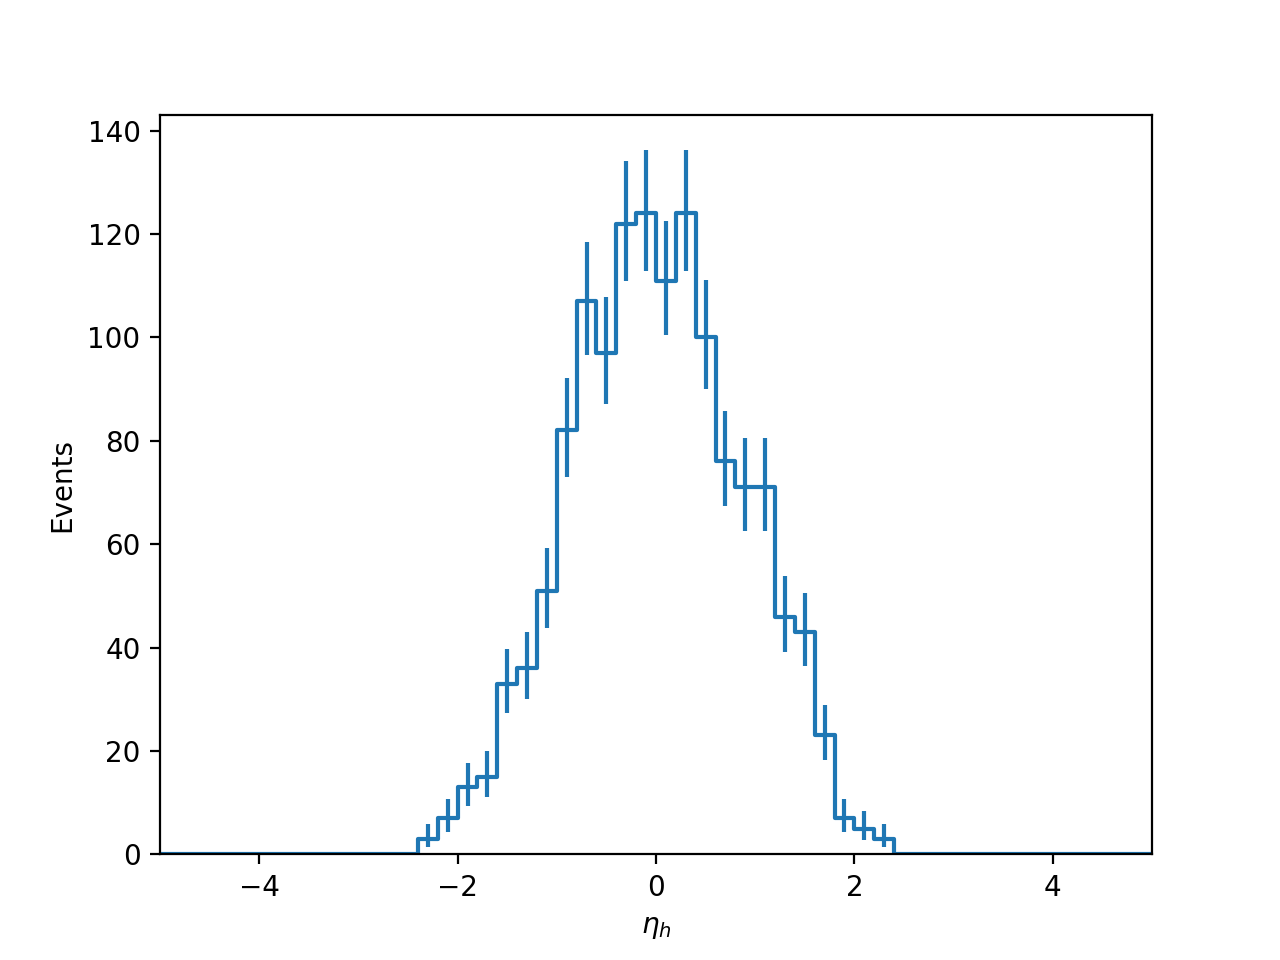

(<Figure size 640x480 with 1 Axes>,
 {'None': [<matplotlib.lines.Line2D at 0x179cc3128>,
   <ErrorbarContainer object of 3 artists>]})

In [9]:
heta = hist.Hist("Events", hist.Bin("eta", r"$\eta_h$", 50, -5, 5))
cut = higgs['p4'].pt > 450.
heta.fill(eta=higgs[cut]['p4'].eta.flatten())
plot.plot1d(heta)

In [18]:
genq = genp[(genp['genPartIdxMother']==0) & (~hidx) & cut.flatten()]
np.unique(genq.counts)

array([0, 3])

In [22]:
mjj = (genq['p4'][:,0:1] + genq['p4'][:,1:2]).mass
detajj = np.abs(genq['p4'][:,0:1].eta - genq['p4'][:,1:2].eta)

In [38]:
vbfcut = ((mjj > 975) & (detajj > 3.25)).sum() == 1
etacut = (np.abs(genq['p4'][:,:2].eta)>2.5).sum() > 0
(etacut & vbfcut).sum() / vbfcut.sum()

0.8620283018867925

<IPython.core.display.Javascript object>


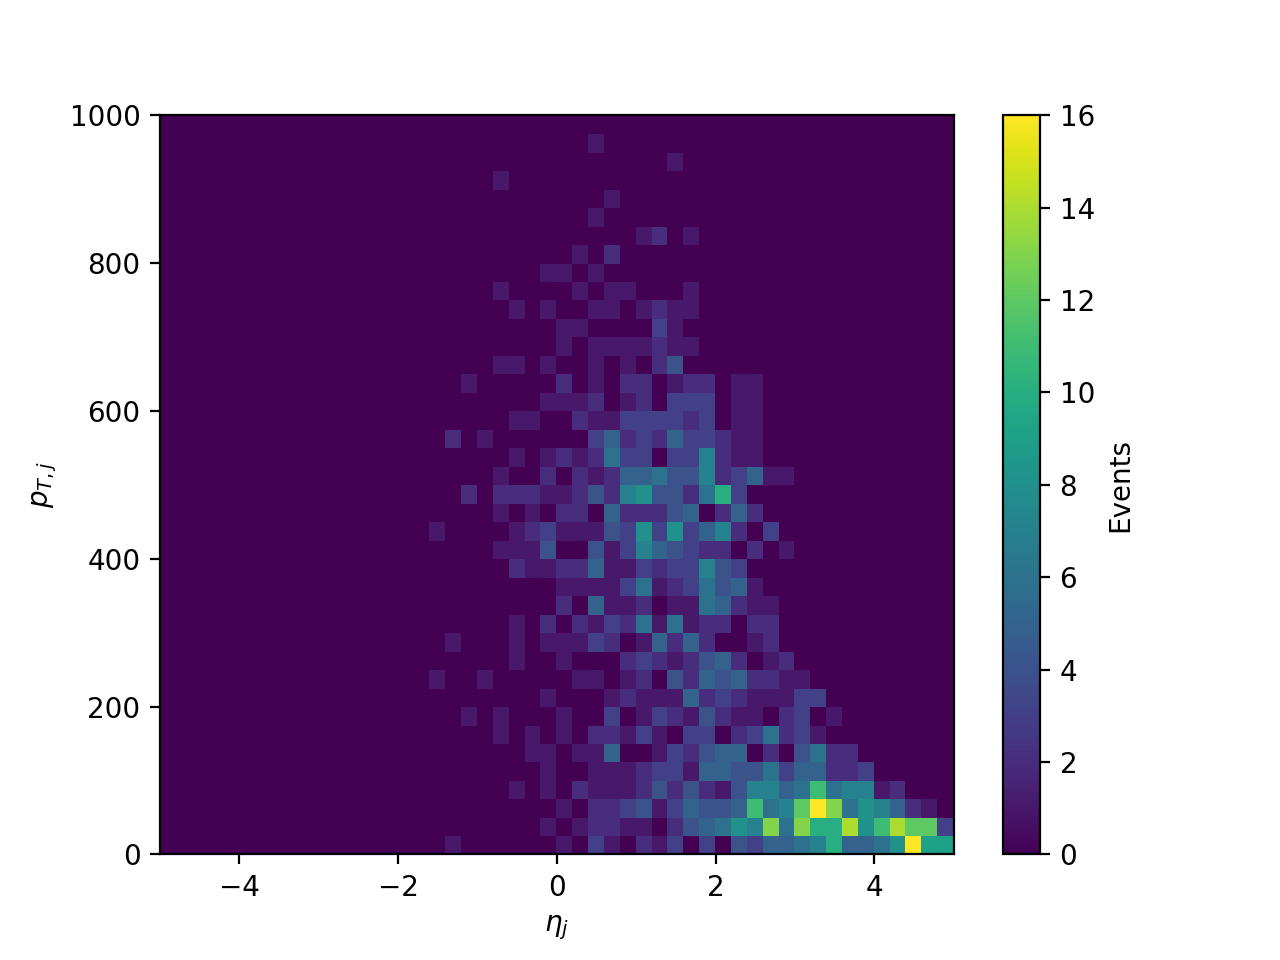

In [39]:
jpt = genq['p4'].pt.pad(3).fillna(0)
jeta = genq['p4'].eta.pad(3).fillna(-100)
hpt = hist.Hist("Events",
                hist.Cat("ijet", "Jet index"),
                hist.Bin("pt", r"$p_{T,j}$", 40, 0, 1000),
                hist.Bin("eta", r"$\eta_j$", 50, -5, 5)
               )
hpt.fill(ijet="0", pt=jpt[:,0].flatten(), eta=jeta[:,0].flatten())
hpt.fill(ijet="1", pt=jpt[:,1].flatten(), eta=jeta[:,1].flatten())
hpt.fill(ijet="2", pt=jpt[:,2].flatten(), eta=jeta[:,2].flatten())
fig, ax, _ = plot.plot2d(hpt.project('ijet', '0'), xaxis='eta')
#ax.set_ylim(1, None)
#ax.set_yscale('log')

In [79]:
bits = {
    0: 'isPrompt',
    1: 'isDecayedLeptonHadron',
    2: 'isTauDecayProduct',
    3: 'isPromptTauDecayProduct',
    4: 'isDirectTauDecayProduct',
    5: 'isDirectPromptTauDecayProduct',
    6: 'isDirectHadronDecayProduct',
    7: 'isHardProcess',
    8: 'fromHardProcess',
    9: 'isHardProcessTauDecayProduct',
    10: 'isDirectHardProcessTauDecayProduct',
    11: 'fromHardProcessBeforeFSR',
    12: 'isFirstCopy',
    13: 'isLastCopy',
    14: 'isLastCopyBeforeFSR'
}
def getbits(num):
    return [v for k, v in bits.items() if num & (1<<k)]

getbits(22913)

['isPrompt',
 'isHardProcess',
 'fromHardProcess',
 'fromHardProcessBeforeFSR',
 'isFirstCopy',
 'isLastCopyBeforeFSR']

In [80]:
getbits(385)

['isPrompt', 'isHardProcess', 'fromHardProcess']